# U-net con transfer learning

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
import tensorflow_datasets as tfdata
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
@tf.function
def load_img(dataset, train=True, input_shape=(256, 256)):
  img_input = tf.image.resize(dataset['image'], (256, 256))
  mask_input = tf.image.resize(dataset['segmentation_mask'], (256,256))
  if train and np.random.uniform()>0.5:
    img_input = tf.image.flip_left_right(img_input)
    mask_input = tf.image.flip_left_right(mask_input)
  img_input, mask_input = tf.cast(img_input, tf.float32)/255.0, mask_input-1
  return img_input, mask_input

In [18]:
class UNet():
  def __init__(self, input_shape=(256,256,3), output_channels=3):
    self.mobilenetv2 = applications.MobileNetV2(input_shape=input_shape, include_top=False)
    self.target_layers = [
                          'block_1_expand_relu',
                          'block_3_expand_relu',
                          'block_6_expand_relu',
                          'block_13_expand_relu',
                          'block_16_project',
    ]
    self.input_shape = input_shape
    self.output_channels = output_channels
    self.model = self.create_model()
    self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

  @staticmethod
  def _upsample(x,filters, kernel_size, dropout=False):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if dropout:
      x = layers.Dropout(0.5)(x)
    x = layers.ReLU()(x)
    return x

  def create_model(self):
    inputs = layers.Input(shape=self.input_shape)
    x = inputs

    ls = [self.mobilenetv2.get_layer(x).output for x in self.target_layers]
    stack_downsample = keras.Model(self.mobilenetv2.input, ls)
    stack_downsample.trainable=False
    skip_layers = stack_downsample(x)
    x = skip_layers[-1]
    skip_layers = list(reversed(skip_layers[:-1]))
    k = 0
    for filters in (512,256,128,64):
      x = self._upsample(x, filters, 4)
      x = layers.Concatenate()([x, skip_layers[k]])
      k+=1
    x = layers.Conv2DTranspose(self.output_channels, 3, strides=2, padding='same')(x)
    x = layers.Softmax()(x)
    return keras.Model(inputs, x)

  @staticmethod
  def _process_mask(mask):
    mask = (mask.numpy() * 127.5).astype('uint8')
    mask = cv.cvtColor(mask, cv.COLOR_GRAY2RGB)
    return mask

  def predict(self, img_path):
    img = np.array(Image.open(img_path))
    img = tf.cast(img, tf.float32)/255.0
    img = tf.image.resize(img, (256, 256))
    mask = self.model.predict(img[tf.newaxis, ...])
    mask = tf.argmax(mask[0], axis=-1)
    mask = self._process_mask(mask)
    img2 = np.hstack([(img.numpy()*255).astype('uint8'), mask])
    plt.figure(figsize=(10,10))
    plt.imshow(img2)
    plt.show()
  

In [19]:
unet = UNet()

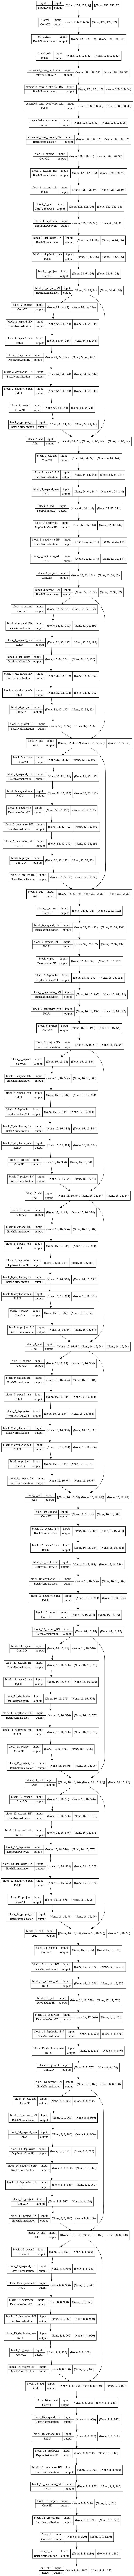

In [12]:
plot_model(unet.mobilenetv2, show_shapes=True)

In [15]:
unet.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           [(None, 128, 128, 9  1841984     ['input_4[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

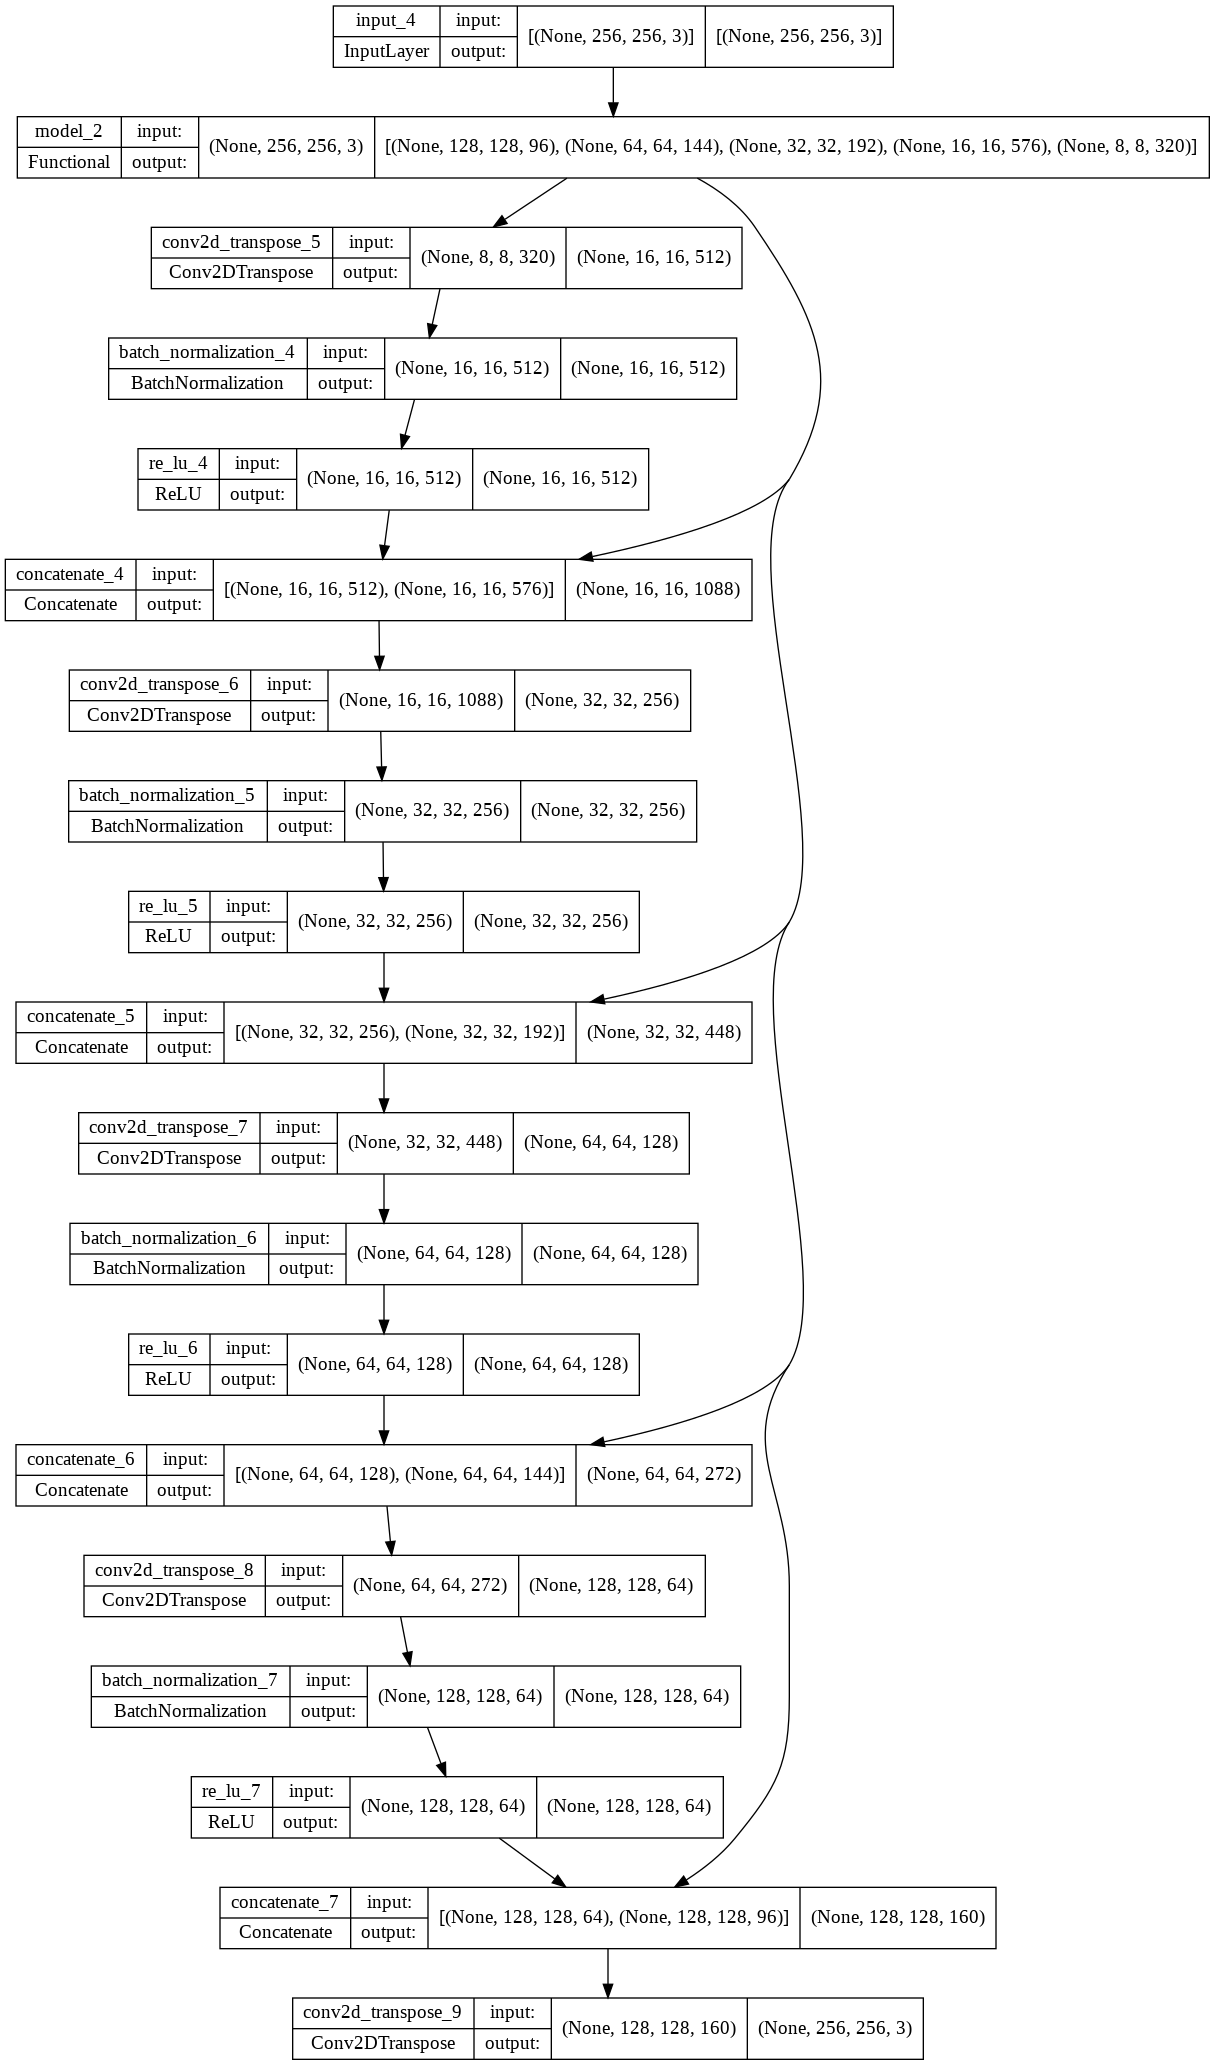

In [16]:
plot_model(unet.model, show_shapes=True)

Dataset

In [9]:
dataset, info = tfdata.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLBOKUC/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLBOKUC/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [10]:
train_dataset = (dataset['train'].map(load_img, num_parallel_calls=AUTOTUNE)
                .shuffle(100).batch(32).prefetch(buffer_size=AUTOTUNE)
                )

test_dataset = (dataset['test'].map(lambda x: load_img(x,train=False), 
                                    num_parallel_calls=AUTOTUNE)
                .batch(32, drop_remainder=True)
                )

In [20]:
unet.model.fit(train_dataset, epochs=12, validation_data= test_dataset,
               validation_steps=5)

Epoch 1/12
115/115 [==============================] - 38s 305ms/step - loss: 0.3648 - acc: 0.8555 - val_loss: 0.2630 - val_acc: 0.8984
Epoch 2/12
115/115 [==============================] - 34s 294ms/step - loss: 0.2492 - acc: 0.8974 - val_loss: 0.2380 - val_acc: 0.9033
Epoch 3/12
115/115 [==============================] - 35s 298ms/step - loss: 0.2348 - acc: 0.9020 - val_loss: 0.2374 - val_acc: 0.9025
Epoch 4/12
115/115 [==============================] - 35s 297ms/step - loss: 0.2270 - acc: 0.9045 - val_loss: 0.2215 - val_acc: 0.9088
Epoch 5/12
115/115 [==============================] - 34s 293ms/step - loss: 0.2207 - acc: 0.9068 - val_loss: 0.2393 - val_acc: 0.9023
Epoch 6/12
115/115 [==============================] - 34s 294ms/step - loss: 0.2134 - acc: 0.9094 - val_loss: 0.2177 - val_acc: 0.9101
Epoch 7/12
115/115 [==============================] - 35s 298ms/step - loss: 0.2083 - acc: 0.9110 - val_loss: 0.2110 - val_acc: 0.9120
Epoch 8/12
115/115 [==============================] - 3

Prueba del modelo

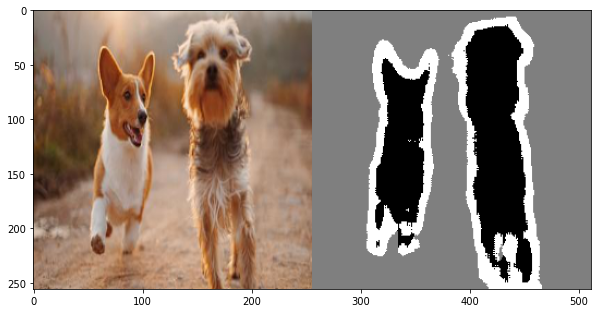

In [21]:
unet.predict('/content/dogs.jpg')

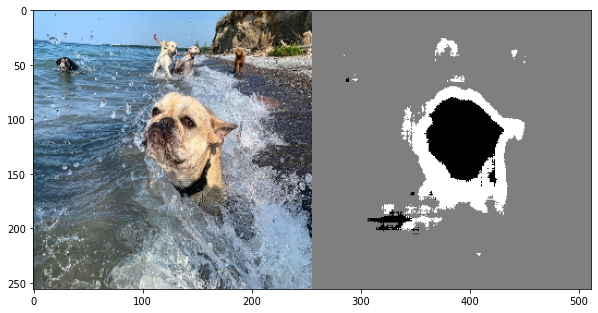

In [22]:
unet.predict('/content/dogs2.jpg')

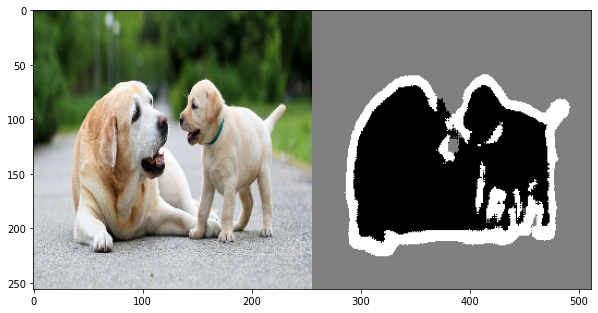

In [23]:
unet.predict('/content/dogs3.jpg')

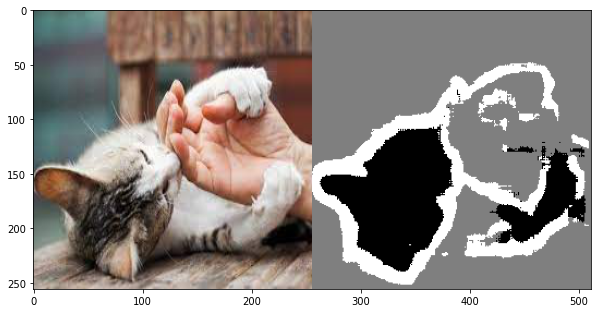

In [24]:
unet.predict('/content/cat.jpg')

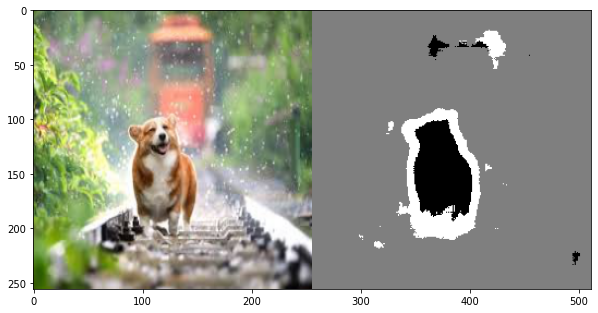

In [25]:
unet.predict('/content/mini_dog.jpg')